In [2]:
%%capture

###############################################
###############################################
# Setup
# This chuck ingests pre-computed variables
###############################################
###############################################

# [Shift + Return] to run chunks 

###############################################

# settings
wkdir, s3dir = '/home/ubuntu/data/DL20181011_melanocyte_test_data', 'daniel.le-work/MEL_project'

%reload_ext autoreload
%autoreload 2
from scanpy_helpers_1 import *
from scanpy_helpers_2 import *
warnings.filterwarnings('ignore')
%matplotlib inline

# import data from s3
for file in ['full_adata', 'DE_df'
            ]:
#     ! aws s3 cp s3://{s3dir}/{file}.p {wkdir}/
    var = pickle.load((open(f'{wkdir}/{file}.p', 'rb')))
    exec(f'{file} = var')
    del var
    
usable_cores = multiprocessing.cpu_count()-1

# update subtypes
full_adata.obs['subtypes'] = ['follicular' if x in ['light_foll_mel', 'dark_foll_mel', 'cyc_foll_mel'] \
                         else y \
                         for x,y in zip(full_adata.obs.class_1, full_adata.obs.subtypes)]

# label order
dev_stage_order = ['fet','neo','adt']
subtypes_order = ['cutaneous','acral','foreskin','follicular']
acral_subtype_order = ['acral','not_acral']
foreskin_subtype_order = ['foreskin','not_foreskin']
follicular_subtype_order = ['follicular','not_follicular']
dev_subtype_order = ['fet_acral','fet_cutaneous','fet_follicular','neo_foreskin','adt_acral','adt_cutaneous']

# create class_2 for site granularity
full_adata.obs['class_2'] = [x if x not in ['mel'] \
                             else f'{y}_mel'
                             for x,y in zip(full_adata.obs['class_1'], full_adata.obs['subtypes'])]

# create class_3 for site+dev_stage granularity
full_adata.obs['class_3'] = [x if not x.endswith('_mel') or x.startswith('cyc_') \
                             else f'{y}_{x}'
                             for x,y in zip(full_adata.obs['class_2'], full_adata.obs['dev_stage'])]

# update class_1 to pool by cell type
full_adata.obs['class_1'] = [x if not x.endswith('_mel') \
                             else 'mel' if not x.startswith('cyc_') \
                             else 'cyc_mel' \
                             for x in full_adata.obs['class_1']]
type_order_1 = ['mel',
                'cyc_mel',
                'krt',
                'cyc_krt',
                'eccrine',
                'cyc_eccrine',
                'dendritic',
                'cyc_dendritic',
                'mast',
                'T_cell',]
    
DE_df['class_1'] = (DE_df['class_1']
                      .astype(str)
                      .astype(CategoricalDtype(type_order_1, ordered=True))
                     )
DE_df = DE_df.dropna()

type_order_2 = ['cutaneous_mel',
                'acral_mel',
                'foreskin_mel',
                'dark_foll_mel',
                'light_foll_mel',
                'cyc_mel',
                'cyc_foll_mel',
                'krt',
                'cyc_krt',
                'eccrine',
                'cyc_eccrine',
                'dendritic',
                'cyc_dendritic',
                'mast',
                'T_cell',]

type_order_3 = ['adt_cutaneous_mel',
                'adt_acral_mel',
                'neo_foreskin_mel',
                'fet_cutaneous_mel',
                'fet_acral_mel',
                'fet_dark_foll_mel',
                'fet_light_foll_mel',
                'cyc_mel',
                'cyc_foll_mel',
                'krt',
                'cyc_krt',
                'eccrine',
                'cyc_eccrine',
                'dendritic',
                'cyc_dendritic',
                'mast',
                'T_cell',]


In [2]:
# # DE test
# print('computing...')
# gene_n = 100
# target_set = ['adt_acral_mel']
# ref_set = ['adt_cutaneous_mel']
# source_groupby = 'class_3'
# input_adata = full_adata

# input_adata = input_adata[[x in target_set+ref_set for x in input_adata.obs[source_groupby]]]
# input_adata.obs['DE_grouping'] = ['target' if x in target_set \
#                             else 'ref' \
#                             for x in input_adata.obs[source_groupby]]

# genelist_adt_acral = fast_DE(input_adata, clusterOI='target', groupby='DE_grouping', reference='ref', gene_n=gene_n)
# genelist_adt_cut = fast_DE(input_adata, clusterOI='ref', groupby='DE_grouping', reference='target', gene_n=gene_n)


In [3]:
# # DE test
# print('computing...')
# gene_n = 100
# target_set = ['fet_acral_mel']
# ref_set = ['fet_cutaneous_mel']
# source_groupby = 'class_3'
# input_adata = full_adata

# input_adata = input_adata[[x in target_set+ref_set for x in input_adata.obs[source_groupby]]]
# input_adata.obs['DE_grouping'] = ['target' if x in target_set \
#                             else 'ref' \
#                             for x in input_adata.obs[source_groupby]]

# genelist_fet_acral = fast_DE(input_adata, clusterOI='target', groupby='DE_grouping', reference='ref', gene_n=gene_n)
# genelist_fet_cut = fast_DE(input_adata, clusterOI='ref', groupby='DE_grouping', reference='target', gene_n=gene_n)


In [4]:
# df = pd.DataFrame({'adt_acral>adt_cut':genelist_adt_acral,
#                    'adt_cut>adt_acral':genelist_adt_cut,
#                    'fet_acral>fet_cut':genelist_fet_acral,
#                    'fet_cut>fet_acral':genelist_fet_cut,
#                   })
# df.to_csv('/home/ubuntu/data/DL20181011_melanocyte_test_data/DE_forRob.csv')

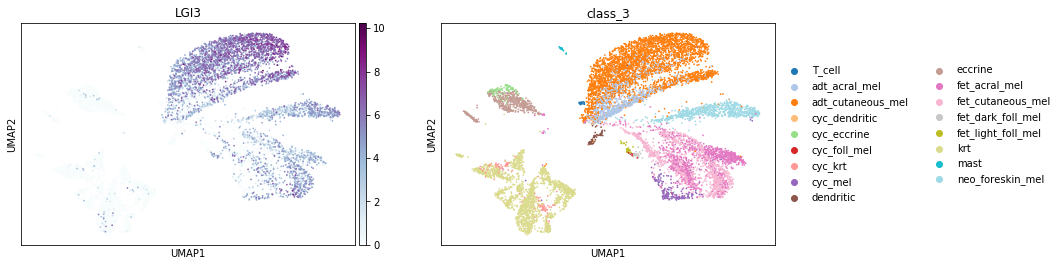

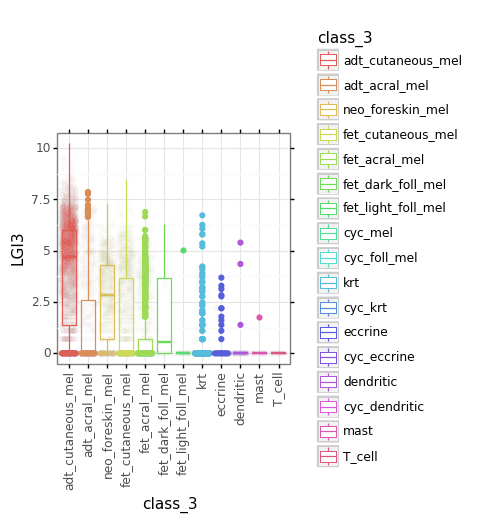

<ggplot: (-9223363250697994019)>
querying 1-1...done.
Finished.
0:  LGI3 
 N/A


In [20]:
# look up gene
gene = 'LGI3'
groupby = 'class_3'
input_adata = full_adata

sc.pl.umap(input_adata, color = [gene,groupby], cmap='BuPu', palette = 'tab20')

cat, plot_df = prepare_dataframe(input_adata[[not x.startswith('cyc') \
                                              for x in input_adata.obs[groupby]]],
                            gene,
                            groupby
                           )

plot_df = plot_df.reset_index()
if groupby == 'class_3':
    plot_df[groupby] = (plot_df[groupby]
                       .astype(str)
                        .astype(CategoricalDtype(type_order_3,ordered=True))
                       )
plot_df = plot_df.dropna()

plotnine.options.figure_size = (3,3)
print(ggplot(plot_df)
      + theme_bw()
      + theme(axis_text_x = element_text(angle = 90))
      + geom_boxplot(aes(groupby, gene, color = groupby))
      + geom_jitter(aes(groupby, gene, color = groupby), alpha = 0.01)
     )

out = symbol2field(gene)
output = [print(f'{idx}: ', 
       x['query'],
       '\n',x['summary']) if ('summary' in x.keys()) else print(f'{idx}: ', 
                                                                x['query'],
                                                                '\n','N/A') for idx, x in enumerate(out)]


In [8]:
print('computing...')
## NTRK2/HPGD look-up
input_adata = full_adata
print(set(input_adata.obs.class_2))
groupby_1 = 'class_2'
groupby_2 = 'patient'

cat, df = prepare_dataframe(input_adata,
                           ['NTRK2','ERBB3'],
                           'cell')
df[groupby_1] = input_adata.obs[groupby_1].values
df[groupby_2] = input_adata.obs[groupby_2].values

# filter on acral vs cutaneous
df = df[[x in ['acral_mel','cutaneous_mel',] for x in df[groupby_1]]]
df.groupby([groupby_1,groupby_2]).mean().dropna().reset_index()

computing...
{'eccrine', 'light_foll_mel', 'cyc_eccrine', 'krt', 'cyc_krt', 'cyc_dendritic', 'mast', 'cutaneous_mel', 'cyc_foll_mel', 'acral_mel', 'cyc_mel', 'dendritic', 'foreskin_mel', 'dark_foll_mel', 'T_cell'}


,class_2,patient,NTRK2,ERBB3
0,acral_mel,10WK03,1.805200,3.483235
1,acral_mel,12WK05,3.936502,4.406474
2,acral_mel,12WKM01,2.381269,3.665097
3,acral_mel,16WKM04,2.301708,3.011860
4,acral_mel,18WKM06,2.213098,3.867733
5,acral_mel,A1038LM,2.166930,2.286014
6,acral_mel,A1046M,2.352038,3.252002
7,cutaneous_mel,9.5WK02,0.842467,3.959283
8,cutaneous_mel,10WK03,0.117757,2.801710
9,cutaneous_mel,12WK05,1.144042,4.256868


In [35]:
input_adata

AnnData object with n_obs × n_vars = 10119 × 24572 
    obs: 'age', 'age_bin', 'plate', 'general_location', 'anatomical_location', 'race', 'sex', 'color', 'patient', 'n_genes', 'n_counts', 'cell', 'cycling_score', 'cycling_cell', 'bsc', 'fsc', 'gate_label', 'contam_1', 'contam_2', 'louvain', 'named_cluster', 'true_year', 'dev_stage', 'subtypes', 'acral_subtype', 'dev_subtype', 'class_1', 'class_2', 'class_3'
    var: 'ribo', 'ercc', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'pca', 'neighbors', 'louvain', 'louvain_colors', 'named_cluster_colors', 'class_1_colors', 'rank_genes_groups', 'class_3_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'

computing...


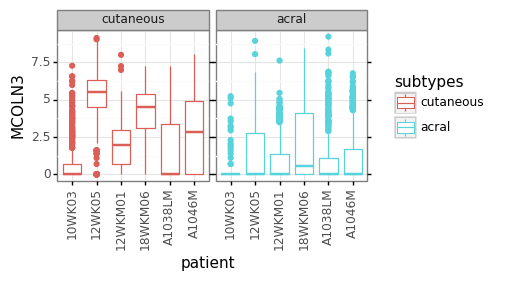

<ggplot: (-9223363257623087805)>


In [6]:
print('computing...')


# gene correlation to bsc
genes = ['MCOLN3']

input_adata = full_adata[full_adata.obs.class_1 == 'mel']
plot_df = pd.DataFrame(input_adata.obs.groupby(['patient','subtypes'])['bsc'].mean()).reset_index()
plot_df = plot_df[[x in ['acral','cutaneous'] for x in plot_df.subtypes]]

# determine samples with acral and cutaneous
filter_df = pd.DataFrame(plot_df['patient'].value_counts())
filter_df = filter_df[filter_df['patient'] > 1]
filter_list = filter_df.index.tolist()

input_adata = full_adata[full_adata.obs.class_1 == 'mel']
input_adata = input_adata[[x in filter_list for x in input_adata.obs.patient]]

for goi in genes:
    cat, df = prepare_dataframe(input_adata,
                                goi,
                                'patient'
                               )
    df = df.reset_index()
    df['subtypes'] = input_adata.obs.subtypes.tolist() 
    df['subtypes'] = (df['subtypes']
                      .astype(str)
                      .astype(CategoricalDtype(['cutaneous','acral'], ordered = True))
                     )
    df = df.dropna()
    plotnine.options.figure_size = (4,4)
    plot = (ggplot(df)
            + theme_bw()
            + theme(axis_text_x = element_text(angle = 90),
                    aspect_ratio = 1)
            + geom_boxplot(aes('patient',goi,color='subtypes'))
            + facet_wrap('~subtypes', ncol = 6)
           )
    print(plot)